In [81]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(dplyr)
library(patchwork)

In [82]:
obj = qs::qread('../00_preprocessing/_targets/objects/exp_other_obob')
obj

An object of class Seurat 
56583 features across 28456 samples within 3 assays 
Active assay: SCT (24262 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [83]:
obj@meta.data = obj@meta.data %>% mutate(batch = stringr::str_replace_all(batch, stringr::fixed(" "), '__'))
obj@meta.data$group = interaction(obj@meta.data$treatment, obj@meta.data$time)

In [84]:
sce = as.SingleCellExperiment(obj)
sce

class: SingleCellExperiment 
dim: 24262 28456 
metadata(0):
assays(2): counts logcounts
rownames(24262): Lypla1 Tcea1 ... Olfr187 ENSMUSG00000100896
rowData names(0):
colnames(28456): CCTATCGAGCCATTCA_1_1 GTCCTCAAGCGAGGAG_1_1 ... TTAATCCGTGATAGTA_5_3 TCACTCGAGGATACCG_5_3
colData names(36): orig.ident nCount_RNA ... group ident
reducedDimNames(2): PCA UMAP
mainExpName: SCT
altExpNames(2): RNA integrated

In [85]:
# reducedDim(sce, "PCA", withDimnames=TRUE) <- obj[['pca']]@cell.embeddings

In [86]:
# sce <- runUMAP(sce, dimred='PCA', name = 'UMAP', n_dimred = 30)

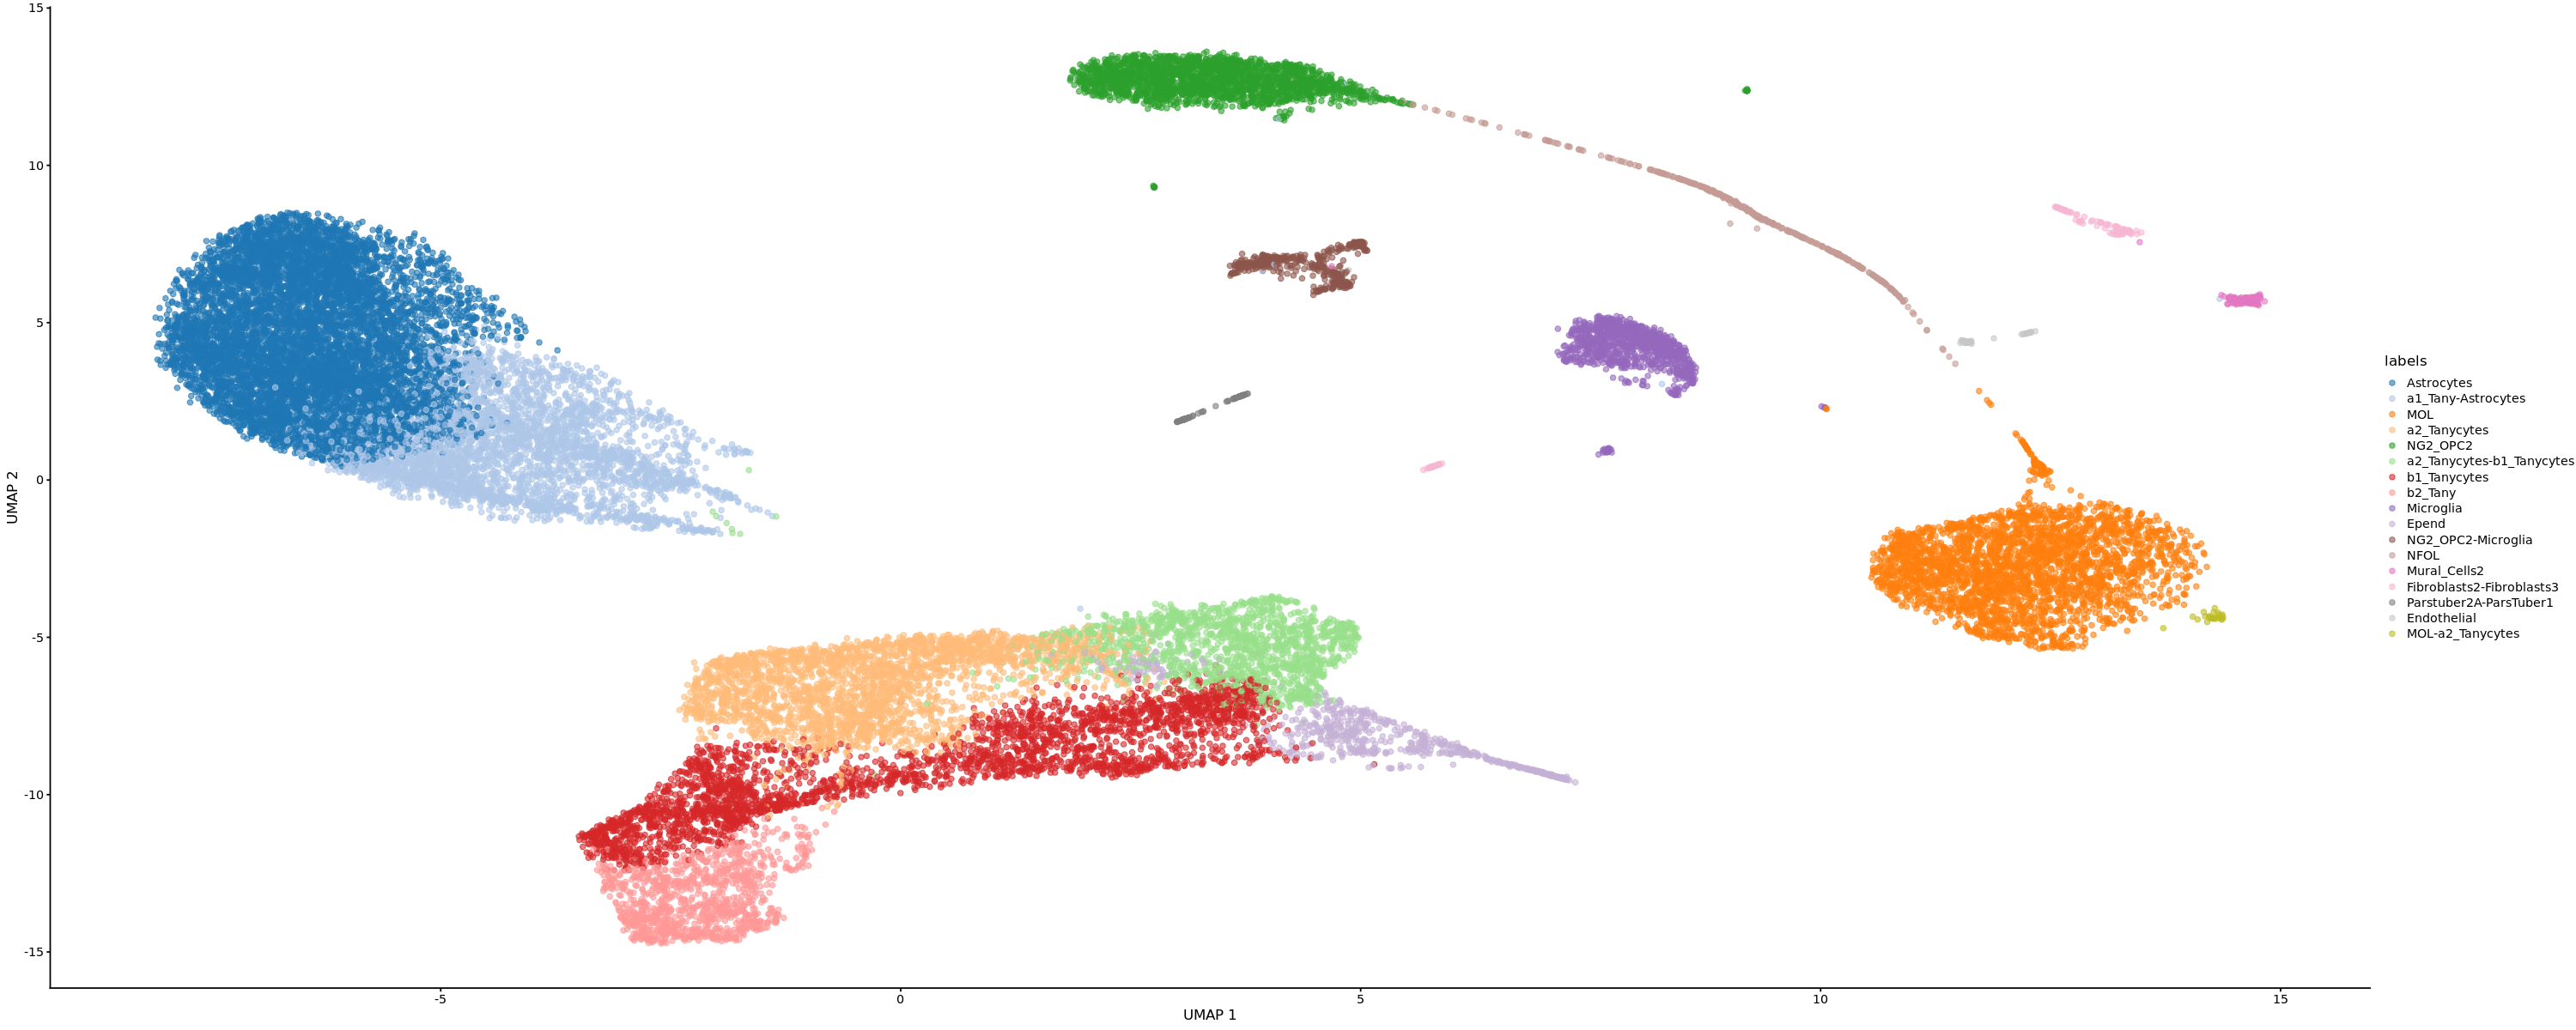

In [87]:
plotReducedDim(sce, colour_by = 'labels', dimred='UMAP')

In [88]:
obob_milo <- Milo(sce)

#build KNN graph
obob_milo <- buildGraph(obob_milo, k=40, d=30, reduced.dim = 'PCA')

#define neighbourhoods
obob_milo <- makeNhoods(obob_milo, prop = 0.1, k= 40, d=30, refined = T, reduced_dims = 'PCA')

Constructing kNN graph with k:40

Checking valid object

Running refined sampling with reduced_dim



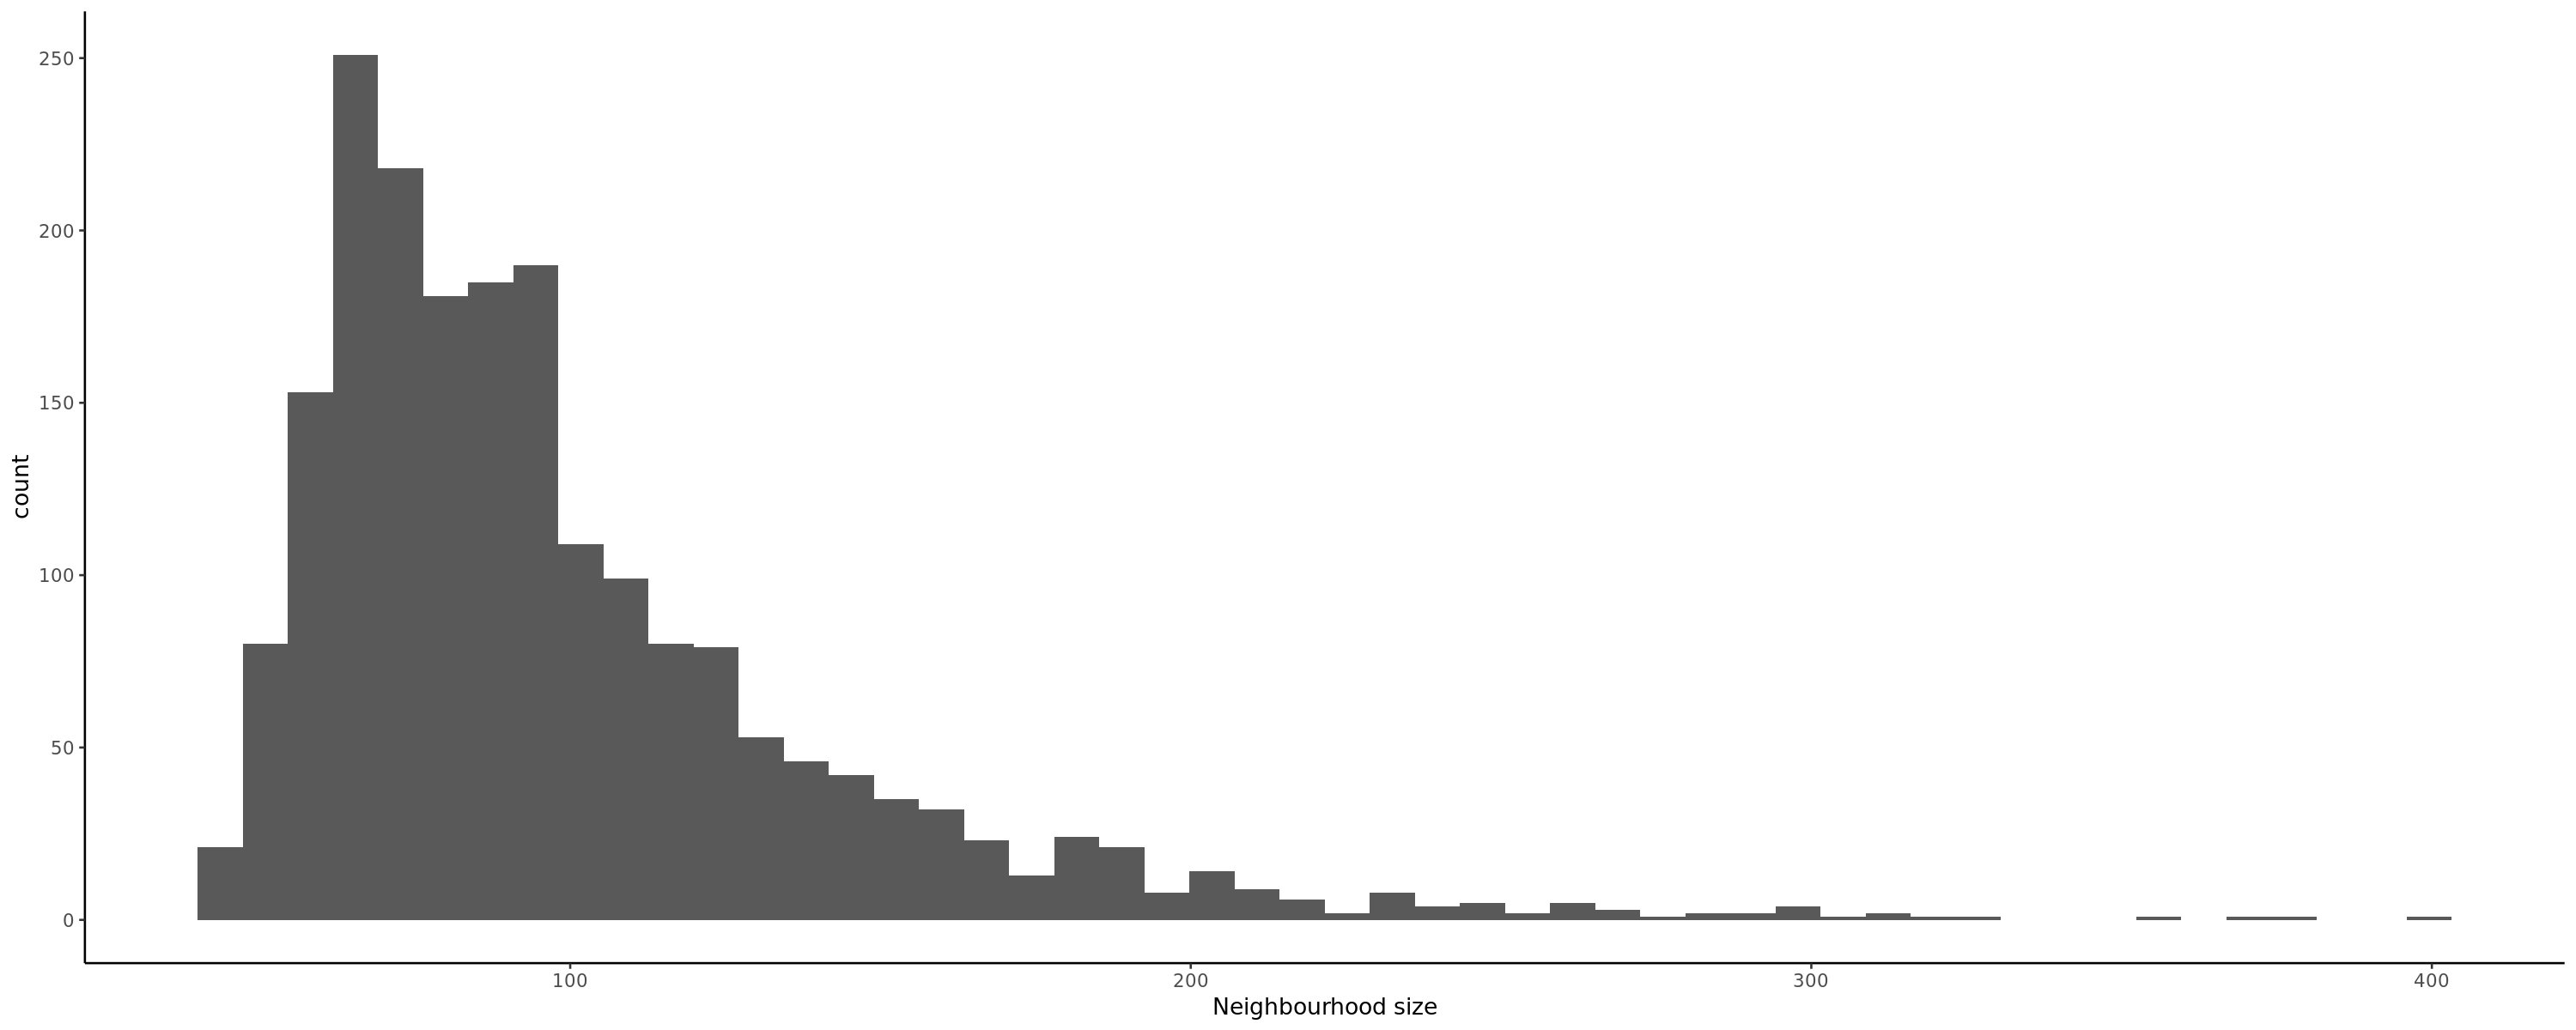

In [89]:
#plot neighbourhood sizes to check if we used appropriate k for graph building
  #we want to have an average size over 5 x N_samples
  #we have 171 samples - but not all samples will be in all neighbourhoods because of age variance
plotNhoodSizeHist(obob_milo)

Checking meta.data validity

Counting cells in neighbourhoods



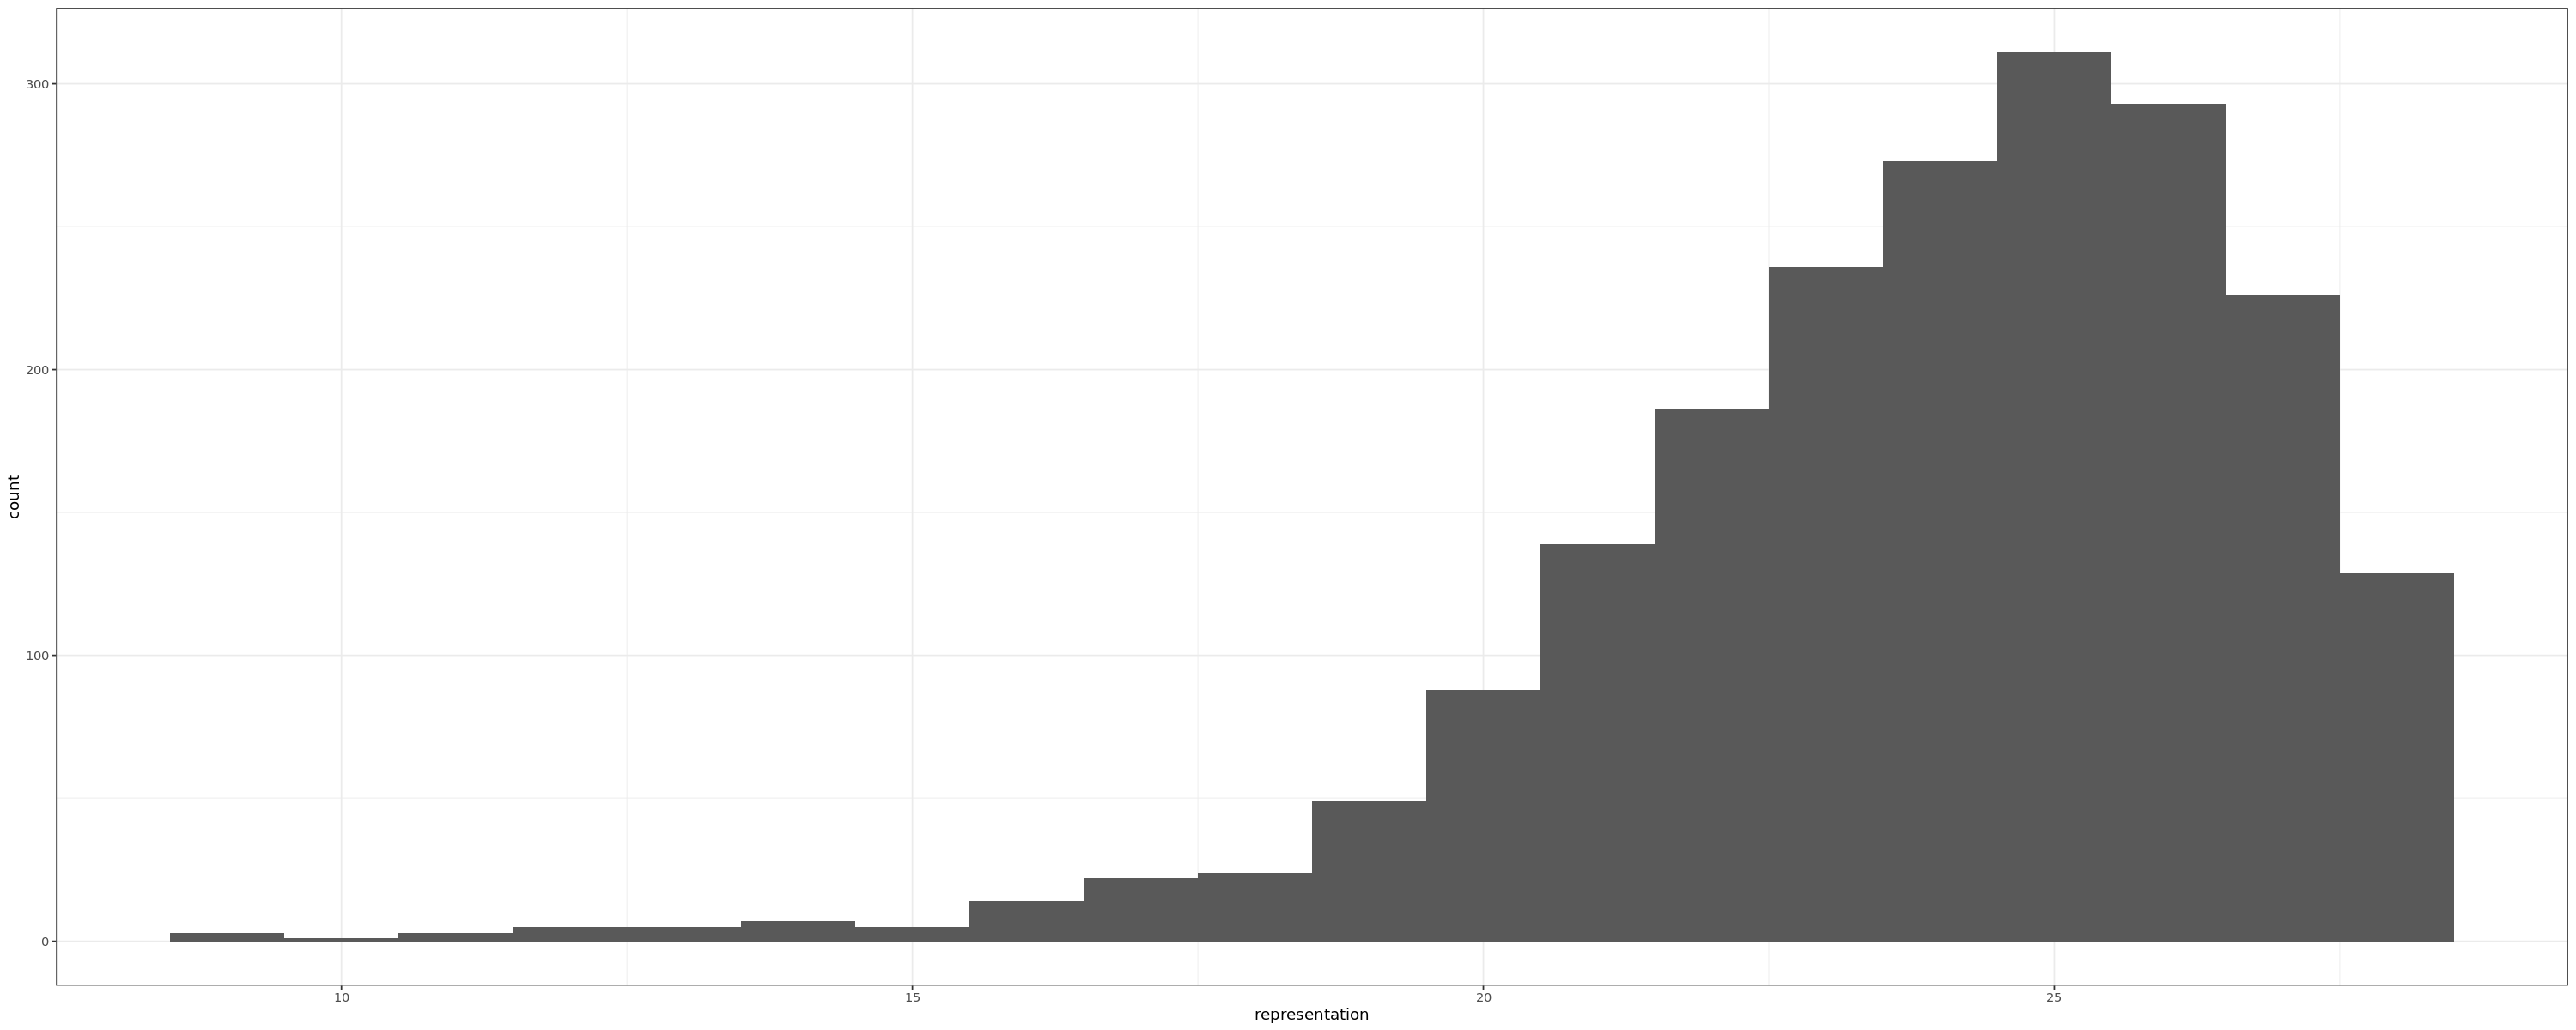

In [90]:
#add a n x m matrix to the milo object with number of neighbourhodds and samples
obob_milo <- countCells(obob_milo, meta.data = as.data.frame(colData(obob_milo)), sample = 'hash.mcl.ID')

#calculate sample representation in each neighbourhood
cell_counts <- as.data.frame(nhoodCounts(obob_milo)) %>% mutate(representation = rowSums(.>0))

#view distribution of N_samples in each neigbourhood
ggplot(cell_counts, aes(x = representation)) + 
  geom_histogram(binwidth = 1) + theme_bw()

#most neighbourhoods have 30-60 samples in them

In [91]:
obob_design <- data.frame(colData(obob_milo))[, c('hash.mcl.ID', 'group', 'batch')]
#convert seq-pool to factor
obob_design$batch <- as.factor(obob_design$batch)
#keep unique rows
obob_design <- distinct(obob_design)
#change rownames
rownames(obob_design) <- obob_design$hash.mcl.ID
head(obob_design)

,hash.mcl.ID,group,batch
,<chr>,<fct>,<fct>
M13,M13,FGF1.Day14,Batch__1
N7,N7,FGF1.Day5,Batch__1
J11,J11,FGF1.Day14,Batch__1
M8,M8,Veh_PF.Day5,Batch__1
J2,J2,Veh_PF.Day14,Batch__1
M24,M24,Veh_PF.Day14,Batch__1


In [92]:
print(obob_design)

    hash.mcl.ID        group    batch
M13         M13   FGF1.Day14 Batch__1
N7           N7    FGF1.Day5 Batch__1
J11         J11   FGF1.Day14 Batch__1
M8           M8  Veh_PF.Day5 Batch__1
J2           J2 Veh_PF.Day14 Batch__1
M24         M24 Veh_PF.Day14 Batch__1
N8           N8  Veh_PF.Day5 Batch__1
M9           M9    FGF1.Day5 Batch__1
N17         N17    FGF1.Day5 Batch__2
M10         M10    FGF1.Day5 Batch__2
M11         M11  Veh_PF.Day5 Batch__2
M23         M23   FGF1.Day14 Batch__2
M25         M25 Veh_PF.Day14 Batch__2
J16         J16   FGF1.Day14 Batch__2
M29         M29 Veh_PF.Day14 Batch__2
N12         N12  Veh_PF.Day5 Batch__2
J7           J7 Veh_PF.Day14 Batch__2
M27         M27   FGF1.Day14 Batch__2
N26         N26    FGF1.Day5 Batch__3
J18         J18   FGF1.Day14 Batch__3
N21         N21    FGF1.Day5 Batch__3
N23         N23  Veh_PF.Day5 Batch__3
M15         M15    FGF1.Day5 Batch__3
J10         J10 Veh_PF.Day14 Batch__3
M28         M28   FGF1.Day14 Batch__3
N13         

In [93]:
length(unique(obob_design$group))

[1] 4

In [94]:
dput(unique(obob_design$group))

structure(c(1L, 3L, 4L, 2L), .Label = c("FGF1.Day14", "Veh_PF.Day14", 
"FGF1.Day5", "Veh_PF.Day5"), class = "factor")


In [95]:
#store distances to nearest neighbours
obob_milo <- calcNhoodDistance(obob_milo, d=30, reduced.dim = 'PCA')
qs::qsave(obob_milo, 'obob_milo.qs')
# obob_milo = qs::qread('obob_milo.qs')

In [96]:
contrast.all = c("groupFGF1.Day5-groupVeh_PF.Day5")
model <- model.matrix(~0 + group, data=obob_design)
mod.contrast <- makeContrasts(contrasts=contrast.all, levels=model)
head(model)

,groupFGF1.Day14,groupVeh_PF.Day14,groupFGF1.Day5,groupVeh_PF.Day5
M13,1,0,0,0
N7,0,0,1,0
J11,1,0,0,0
M8,0,0,0,1
J2,0,1,0,0
M24,0,1,0,0


In [97]:
options(width=120) 
print(model)

    groupFGF1.Day14 groupVeh_PF.Day14 groupFGF1.Day5 groupVeh_PF.Day5
M13               1                 0              0                0
N7                0                 0              1                0
J11               1                 0              0                0
M8                0                 0              0                1
J2                0                 1              0                0
M24               0                 1              0                0
N8                0                 0              0                1
M9                0                 0              1                0
N17               0                 0              1                0
M10               0                 0              1                0
M11               0                 0              0                1
M23               1                 0              0                0
M25               0                 1              0                0
J16               1 

In [98]:
print(mod.contrast)

                   Contrasts
Levels              groupFGF1.Day5-groupVeh_PF.Day5
  groupFGF1.Day14                                 0
  groupVeh_PF.Day14                               0
  groupFGF1.Day5                                  1
  groupVeh_PF.Day5                               -1


In [99]:
# da_results <- testNhoods(obob_milo, design = model, design.df = obob_design) #works!
da_results <- testNhoods(obob_milo, design = model, design.df = obob_design, model.contrasts = c("groupFGF1.Day14-groupVeh_PF.Day14"))

da_results %>%
  arrange(SpatialFDR) %>%
  head()

table(da_results$FDR < 0.1)

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
388,2.021759,9.422981,11.91808,0.0008830411,0.2579099,388,0.812306
527,4.151768,9.032102,12.04805,0.0008597256,0.2579099,527,0.812306
764,4.151768,9.032102,12.04805,0.0008597256,0.2579099,764,0.812306
991,2.415916,9.502714,11.89127,0.0008941900,0.2579099,991,0.812306
1273,2.643145,9.234503,12.69329,0.0006157466,0.2579099,1273,0.812306
1452,4.413427,9.074693,13.63967,0.0004158207,0.2579099,1452,0.812306



FALSE 
 2019 

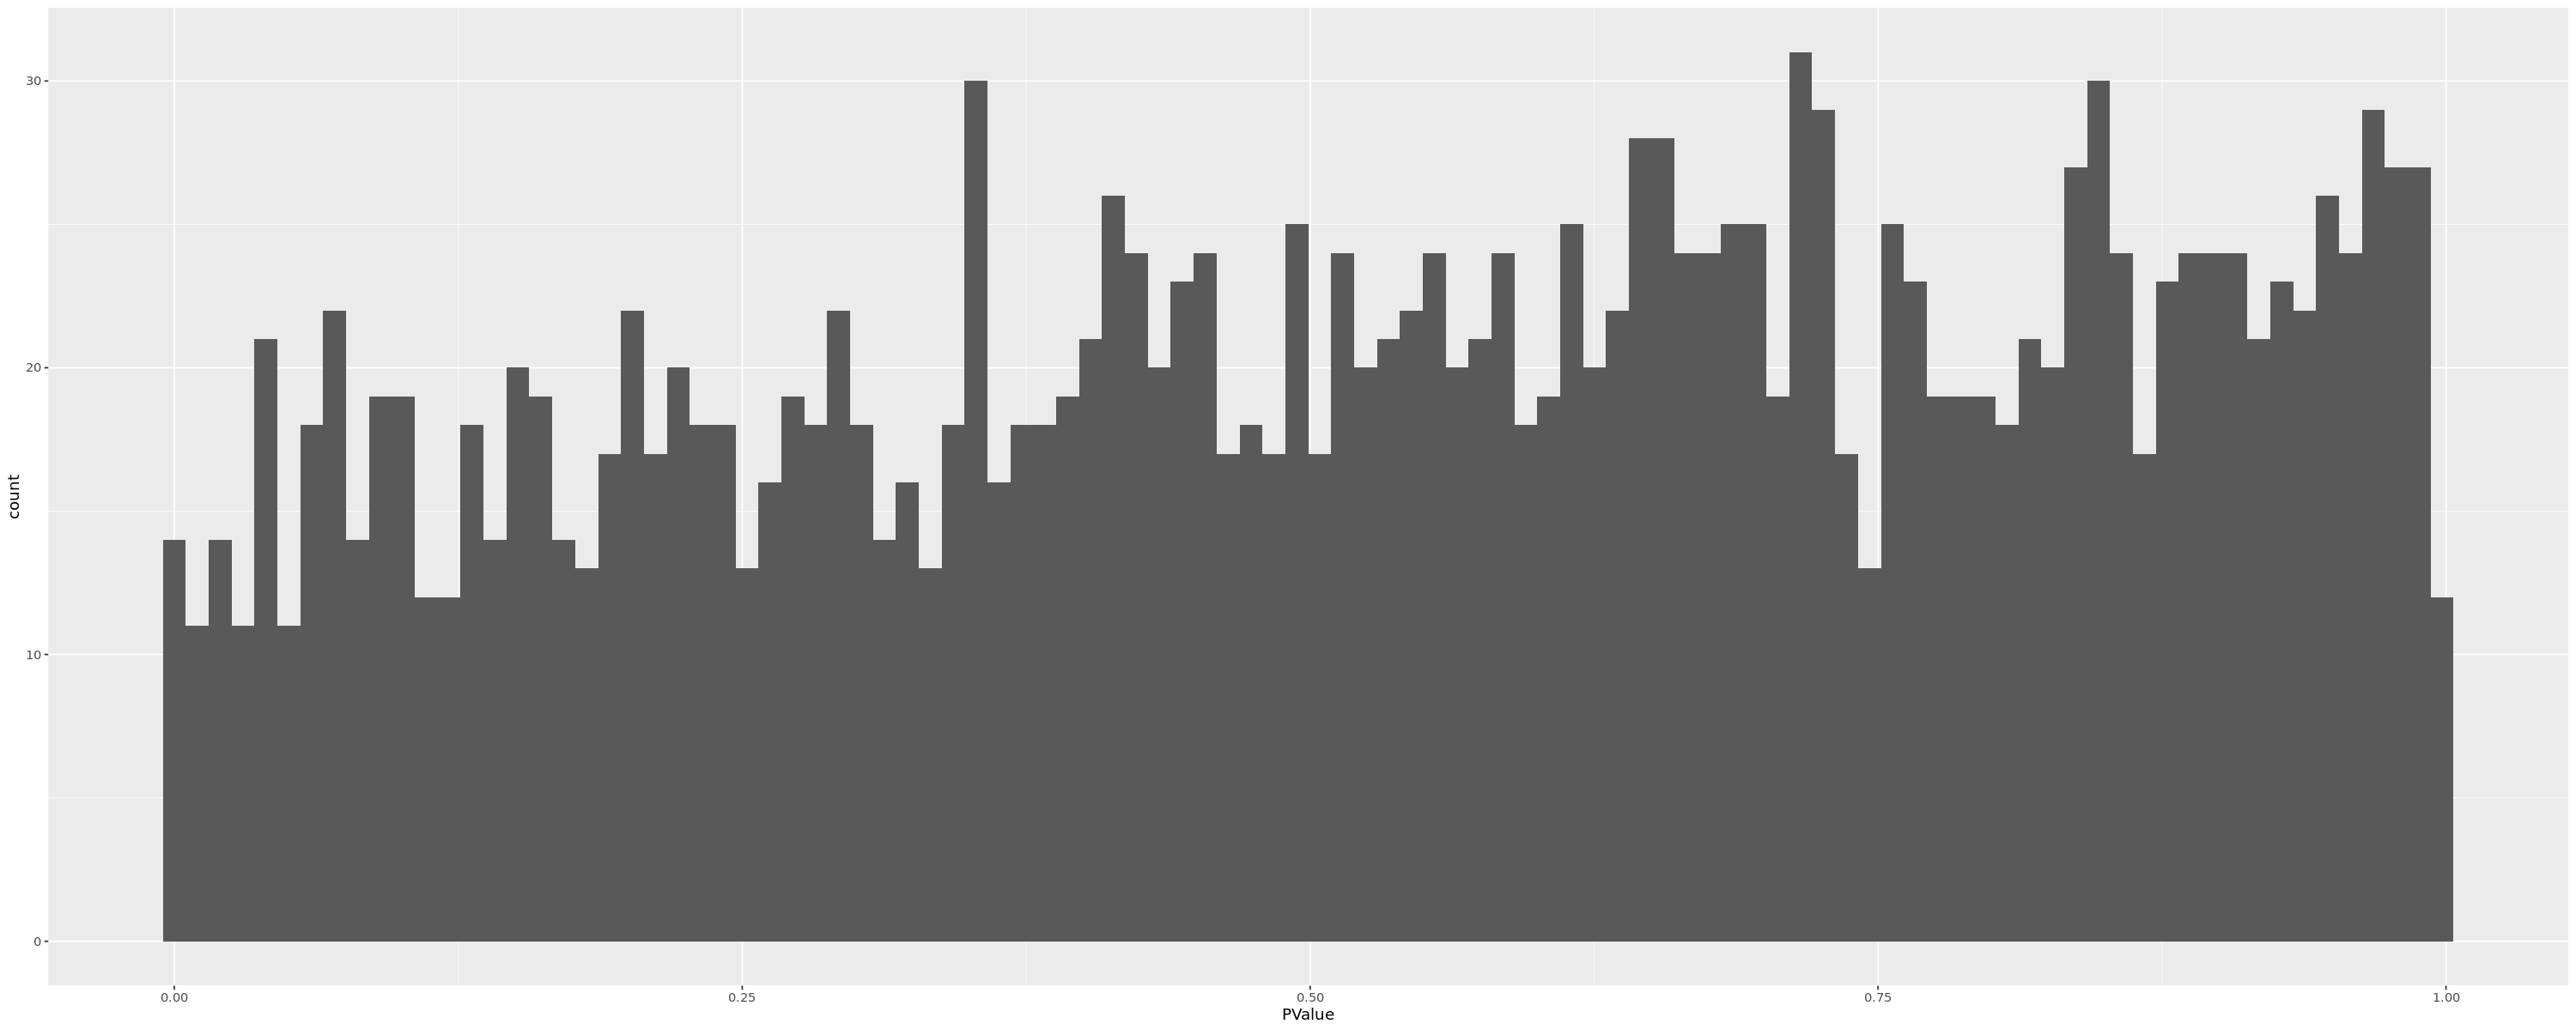

In [100]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=100)

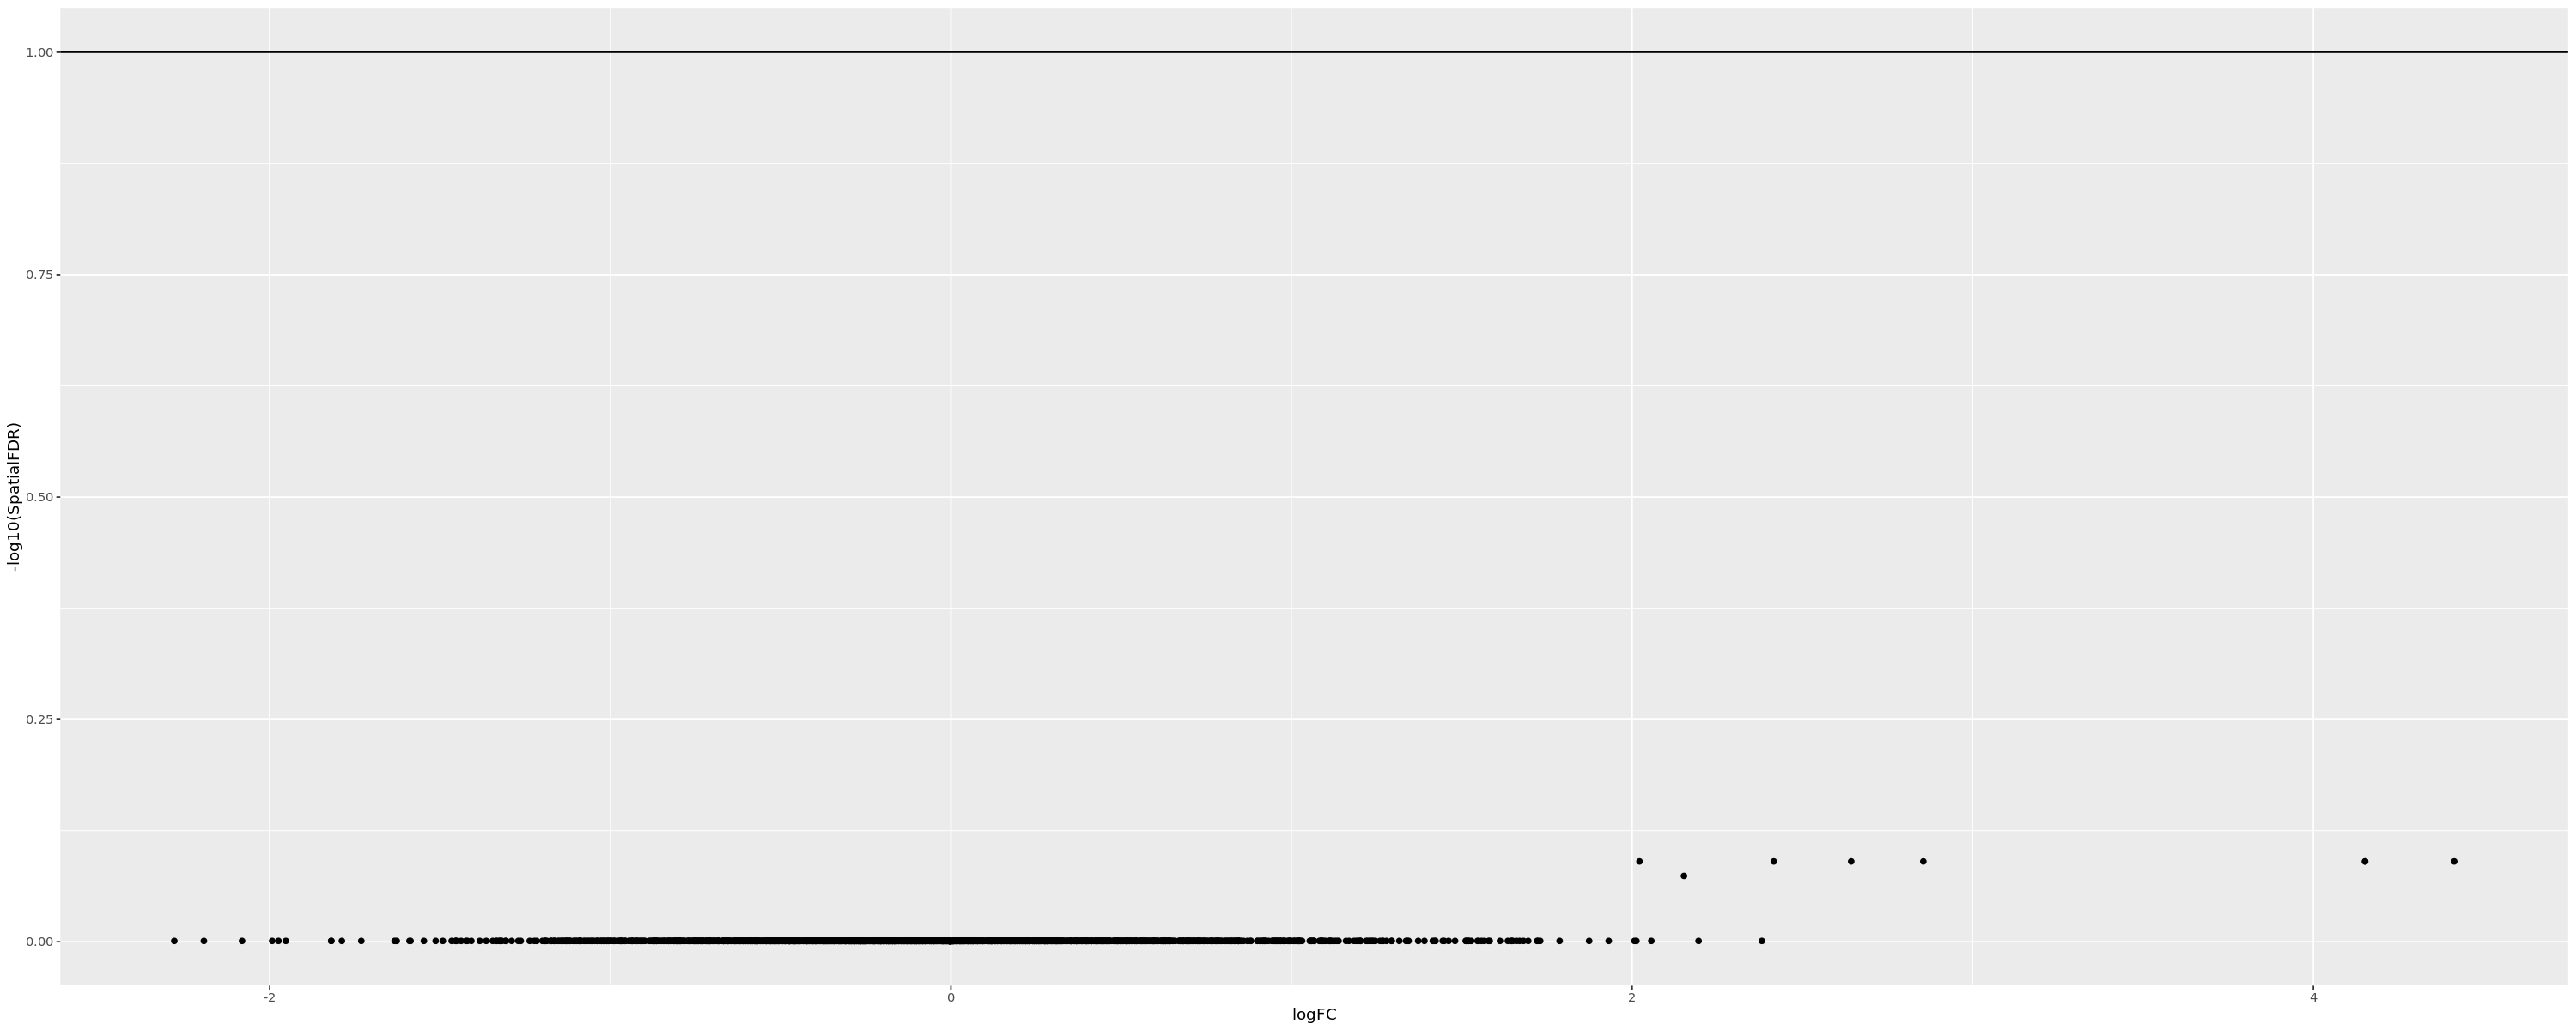

In [101]:
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) ## Mark significance threshold (10% FDR)

In [102]:
obob_milo <- buildNhoodGraph(obob_milo)

In [103]:
head(data.frame(colData(obob_milo)))

,orig.ident,nCount_RNA,nFeature_RNA,Index.10x,nCount_HTO,nFeature_HTO,Index.HTO,nCount_spliced,nFeature_spliced,nCount_unspliced,⋯,treatment,time,collection_date,isolation_date,batch,predicted.id,prediction.score.max,labels,group,ident
,<chr>,<dbl>,<int>,<chr>,<dbl>,<int>,<chr>,<dbl>,<int>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>
CCTATCGAGCCATTCA_1_1,SI-TT-A11,49695,7017,SI-TT-A11,1473,12,D706,7105,3206,42590,⋯,FGF1,Day14,220407,22/6/2022,Batch__1,NG2_OPC2,0.3917772,NG2_OPC2-Microglia,FGF1.Day14,12
GTCCTCAAGCGAGGAG_1_1,SI-TT-A11,41375,6414,SI-TT-A11,2757,12,D706,6392,2838,34983,⋯,FGF1,Day5,211213,22/6/2022,Batch__1,NFOL,1.0000000,NFOL,FGF1.Day5,13
AAGGTAATCTGAGGCC_1_1,SI-TT-A11,40000,6407,SI-TT-A11,1678,12,D706,5088,2532,34912,⋯,FGF1,Day14,220131,22/6/2022,Batch__1,NG2_OPC2,0.9625983,NG2_OPC2-Microglia,FGF1.Day14,12
TCCGTGTCACCTGTCT_1_1,SI-TT-A11,39270,6913,SI-TT-A11,1516,12,D706,6058,2883,33212,⋯,FGF1,Day14,220407,22/6/2022,Batch__1,Parstuber2A,0.2406799,NG2_OPC2-Microglia,FGF1.Day14,12
CTTCGGTTCAGCTGAT_1_1,SI-TT-A11,40118,5968,SI-TT-A11,2558,12,D706,7081,2634,33037,⋯,FGF1,Day5,211213,22/6/2022,Batch__1,NFOL,0.9833581,NFOL,FGF1.Day5,13
TCTAACTCAATCTCGA_1_1,SI-TT-A11,35178,6131,SI-TT-A11,1966,12,D706,4758,2406,30420,⋯,FGF1,Day14,220131,22/6/2022,Batch__1,NG2_OPC2,0.4448438,NG2_OPC2-Microglia,FGF1.Day14,12


In [104]:
umap_pl <- plotReducedDim(obob_milo, dimred = "UMAP", colour_by="labels", text_by = "labels", 
                          text_size = 3, point_size=0.5) +
  guides(fill="none")

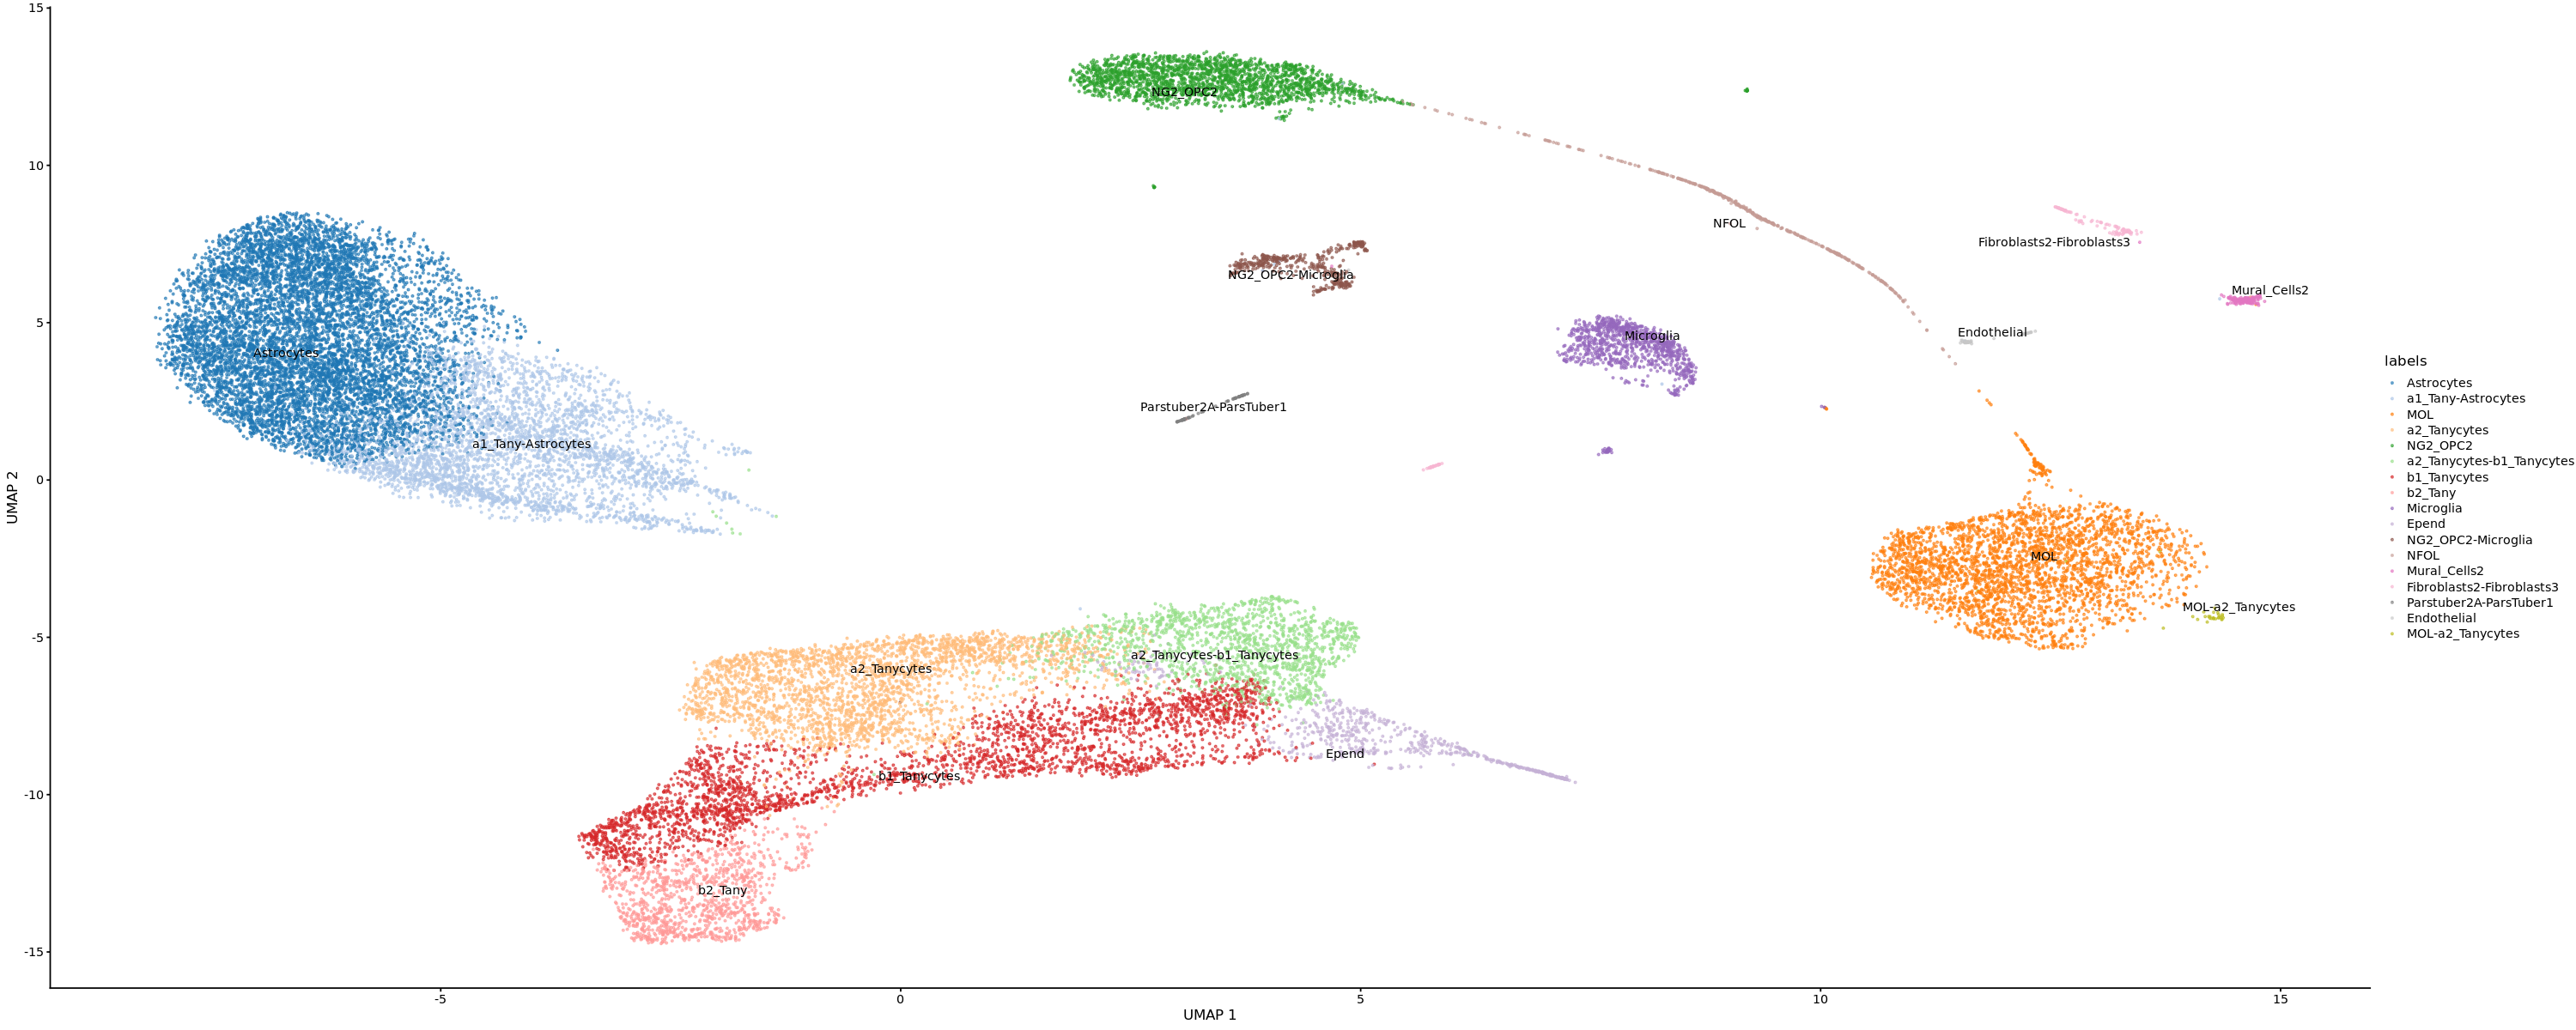

In [105]:
umap_pl

In [106]:
nh_graph_pl <- plotNhoodGraphDA(obob_milo, da_results, layout="UMAP",alpha=0.1, size_range = c(0.5,2)) 

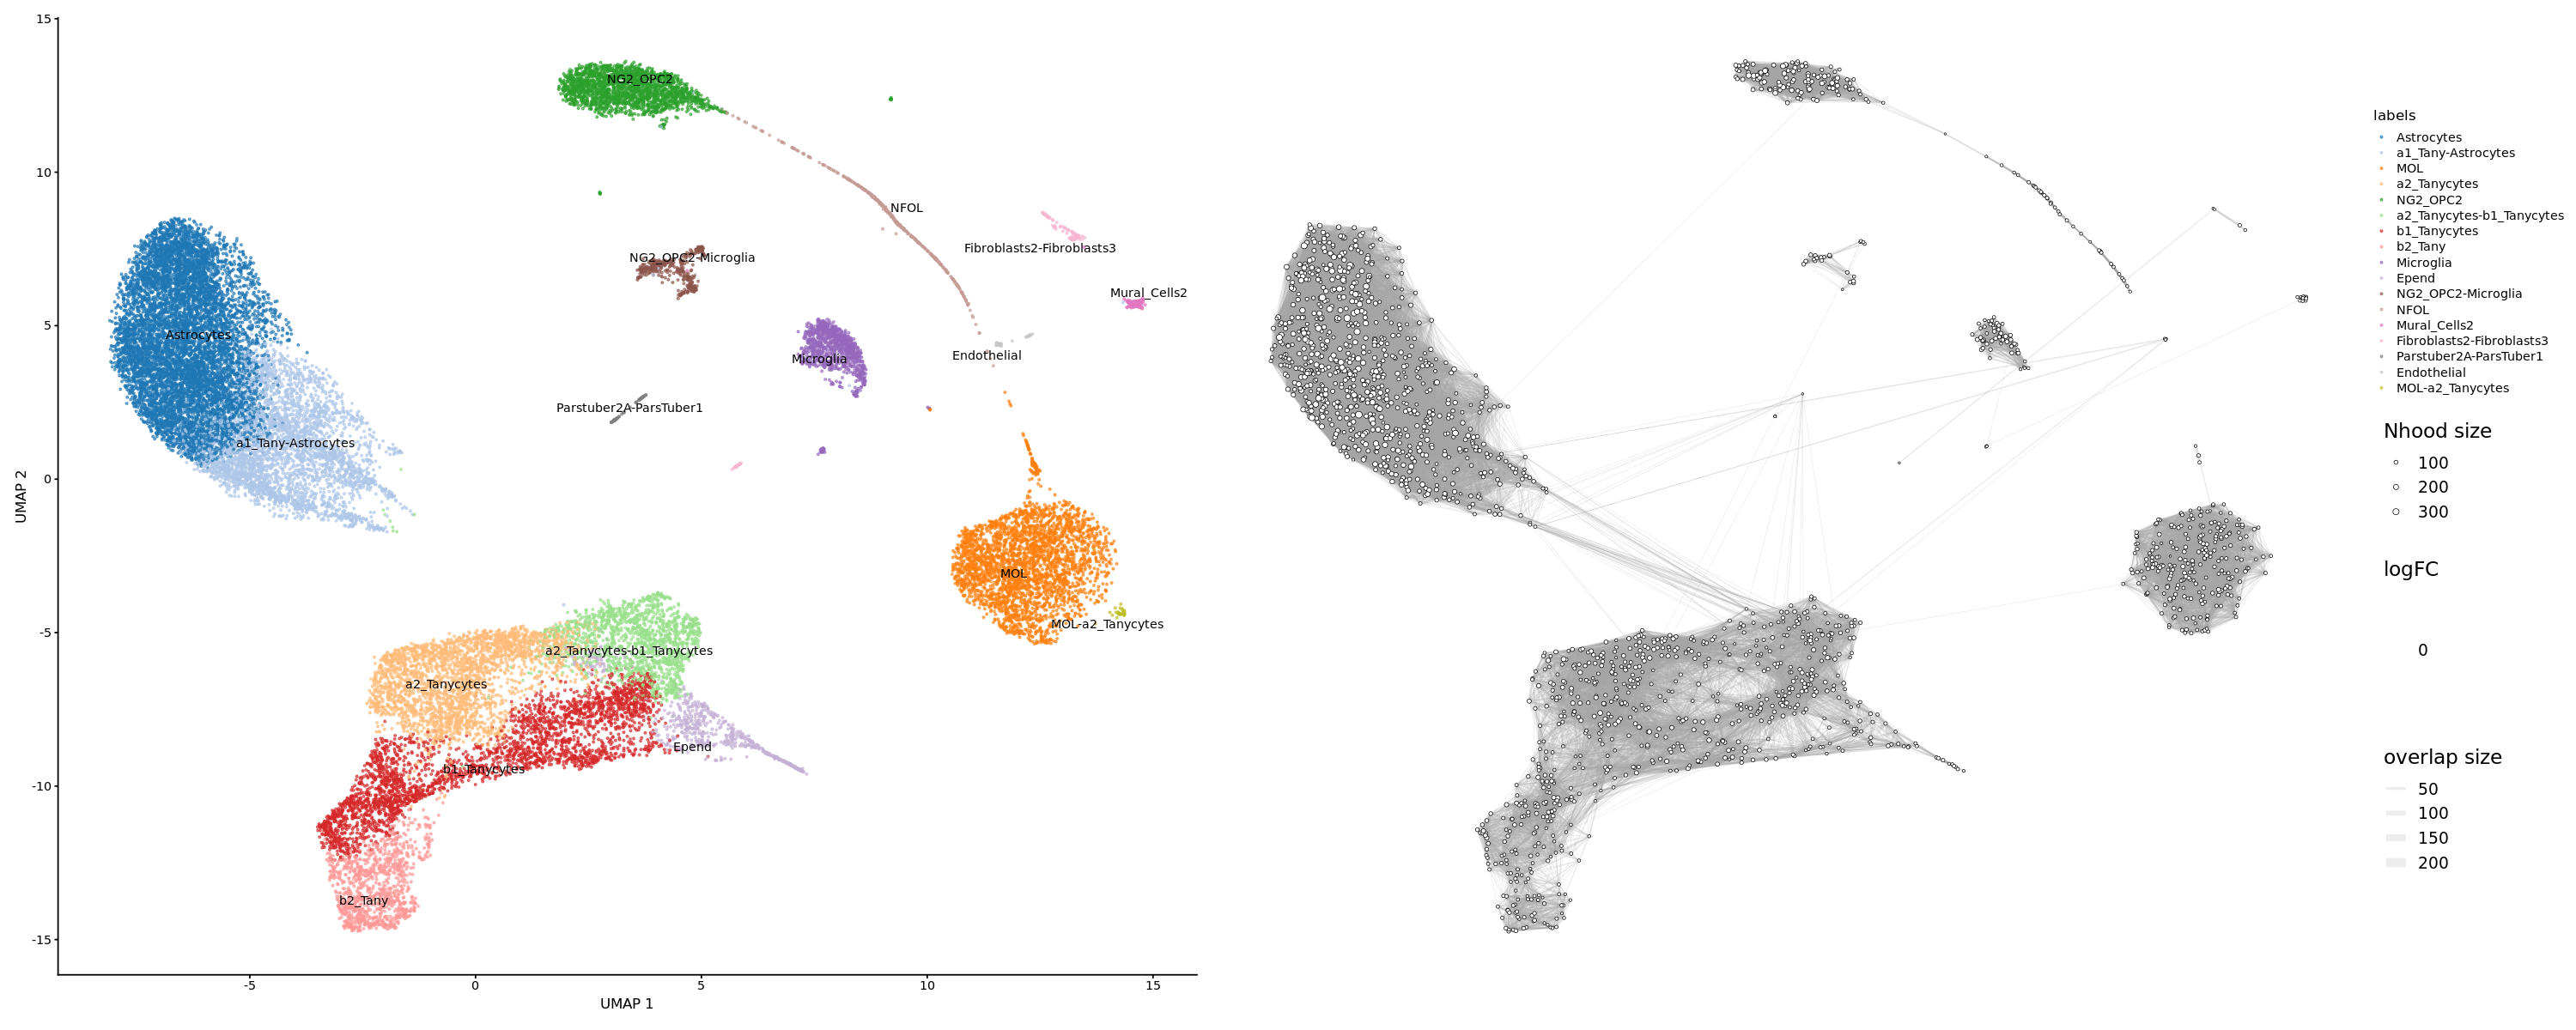

In [107]:
options(repr.plot.width=25, repr.plot.height=10)
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [108]:
da_results <- annotateNhoods(obob_milo, da_results, coldata_col = "labels")
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,labels,labels_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.09799752,9.485982,0.02508872,0.87453701,0.9980466,1,0.9979265,Astrocytes,1.0000000
2,0.48020498,9.743802,0.73566460,0.39356211,0.9980466,2,0.9979265,a2_Tanycytes,1.0000000
3,0.48795316,9.246855,0.55439651,0.45866300,0.9980466,3,0.9979265,NG2_OPC2,1.0000000
4,1.68091313,9.113271,6.42480630,0.01316183,0.9980466,4,0.9979265,MOL,0.9807692
5,-1.17527092,9.566744,2.97642164,0.08826636,0.9980466,5,0.9979265,Astrocytes,0.5604396
6,0.57900372,9.814898,1.17723562,0.28111044,0.9980466,6,0.9979265,a2_Tanycytes,0.9756098


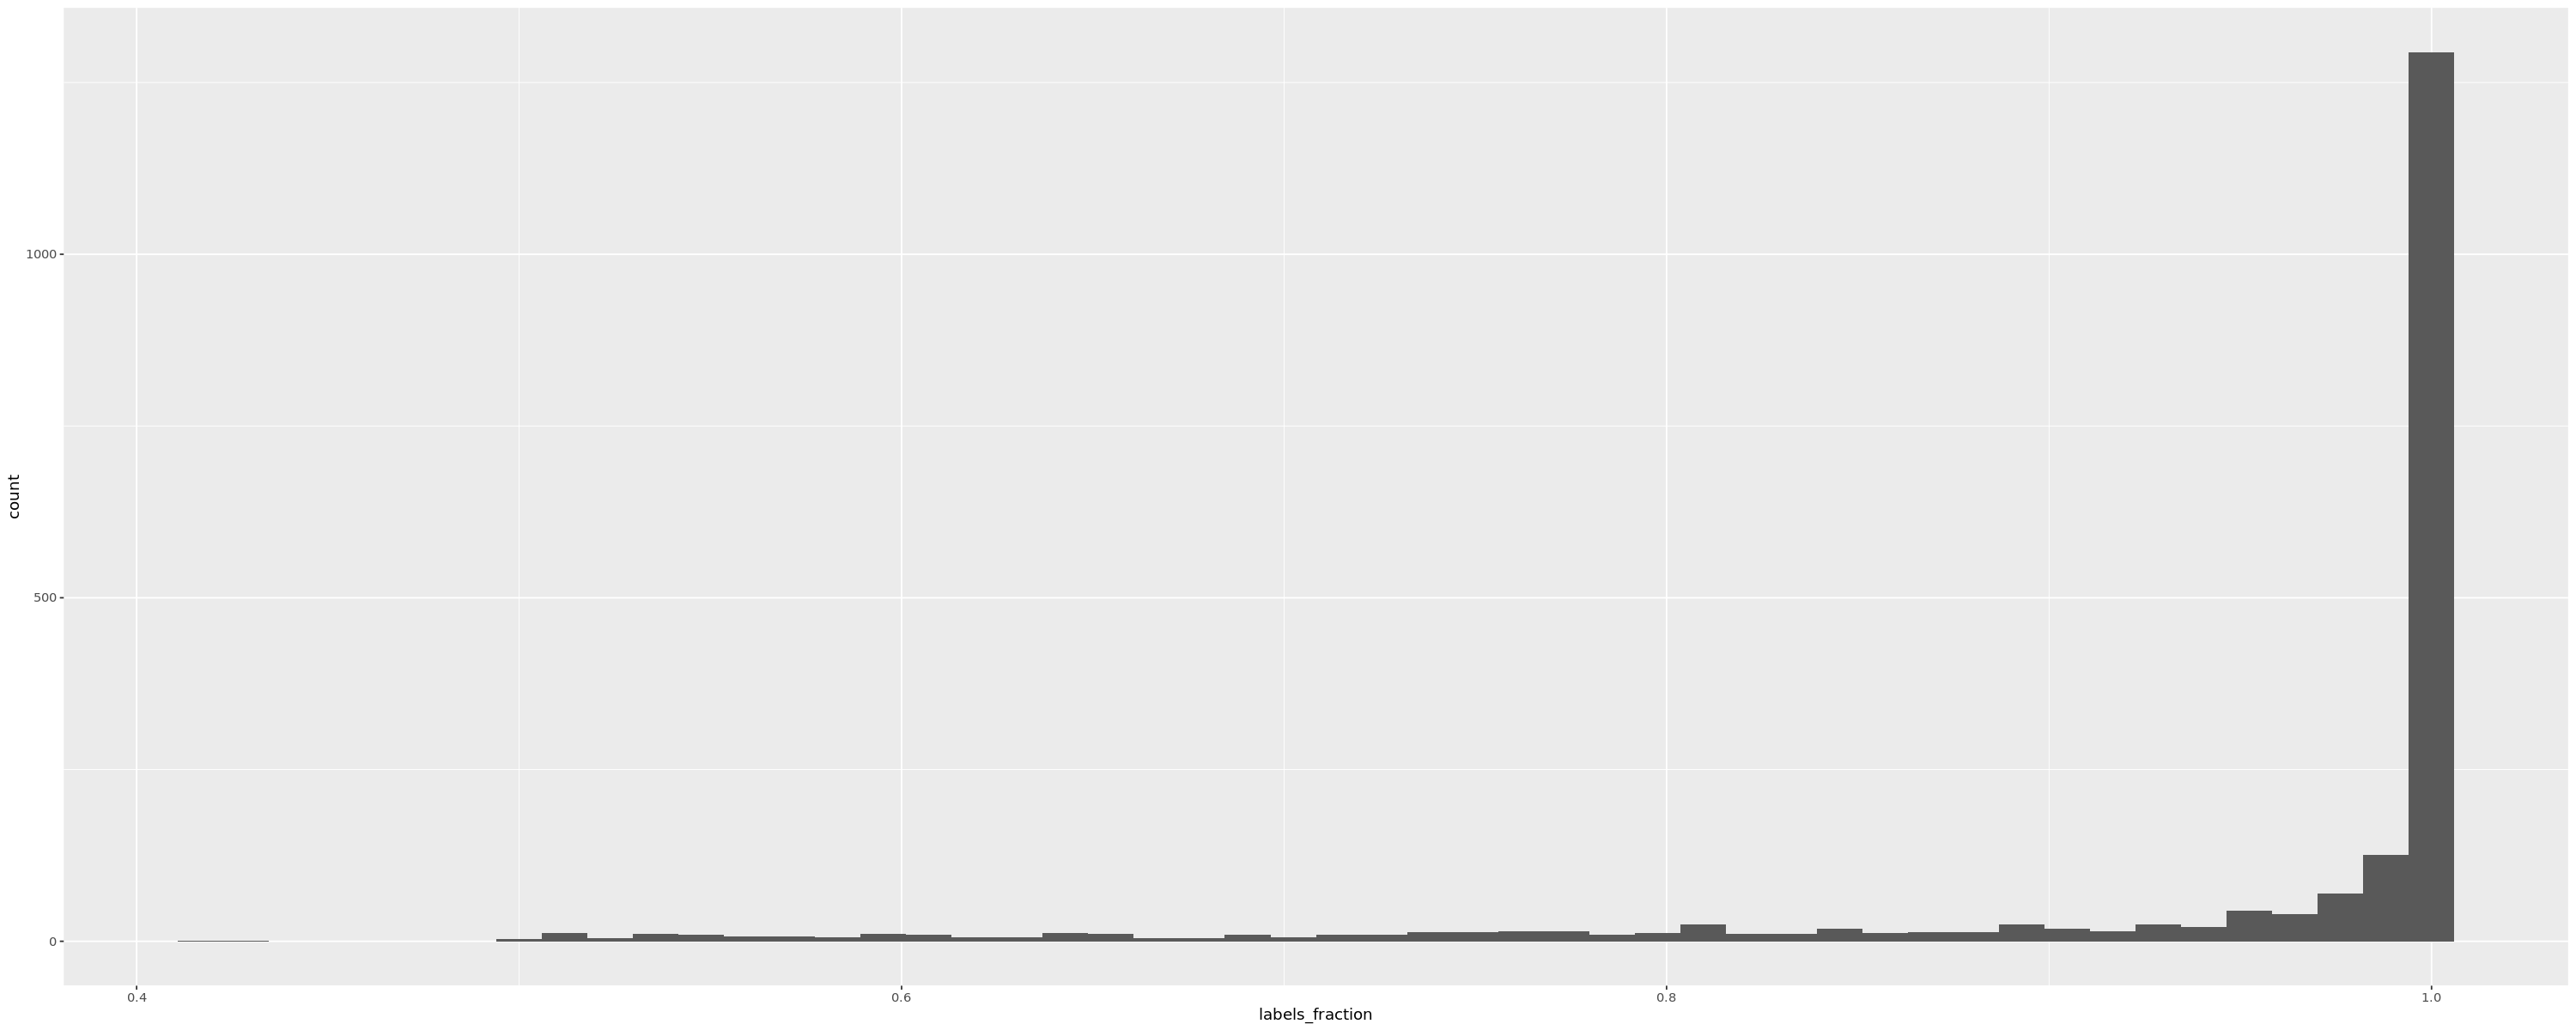

In [109]:
#we want to set a threshold to exclude neighbourhoods with a mix of cell types
ggplot(da_results, aes(labels_fraction)) + geom_histogram(bins=50)

In [110]:
da_results$labels <- ifelse(da_results$labels_fraction < 0.7, "Mixed", da_results$labels)

Converting group.by to factor...

ERROR while rich displaying an object: Error: Discrete value supplied to continuous scale

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj

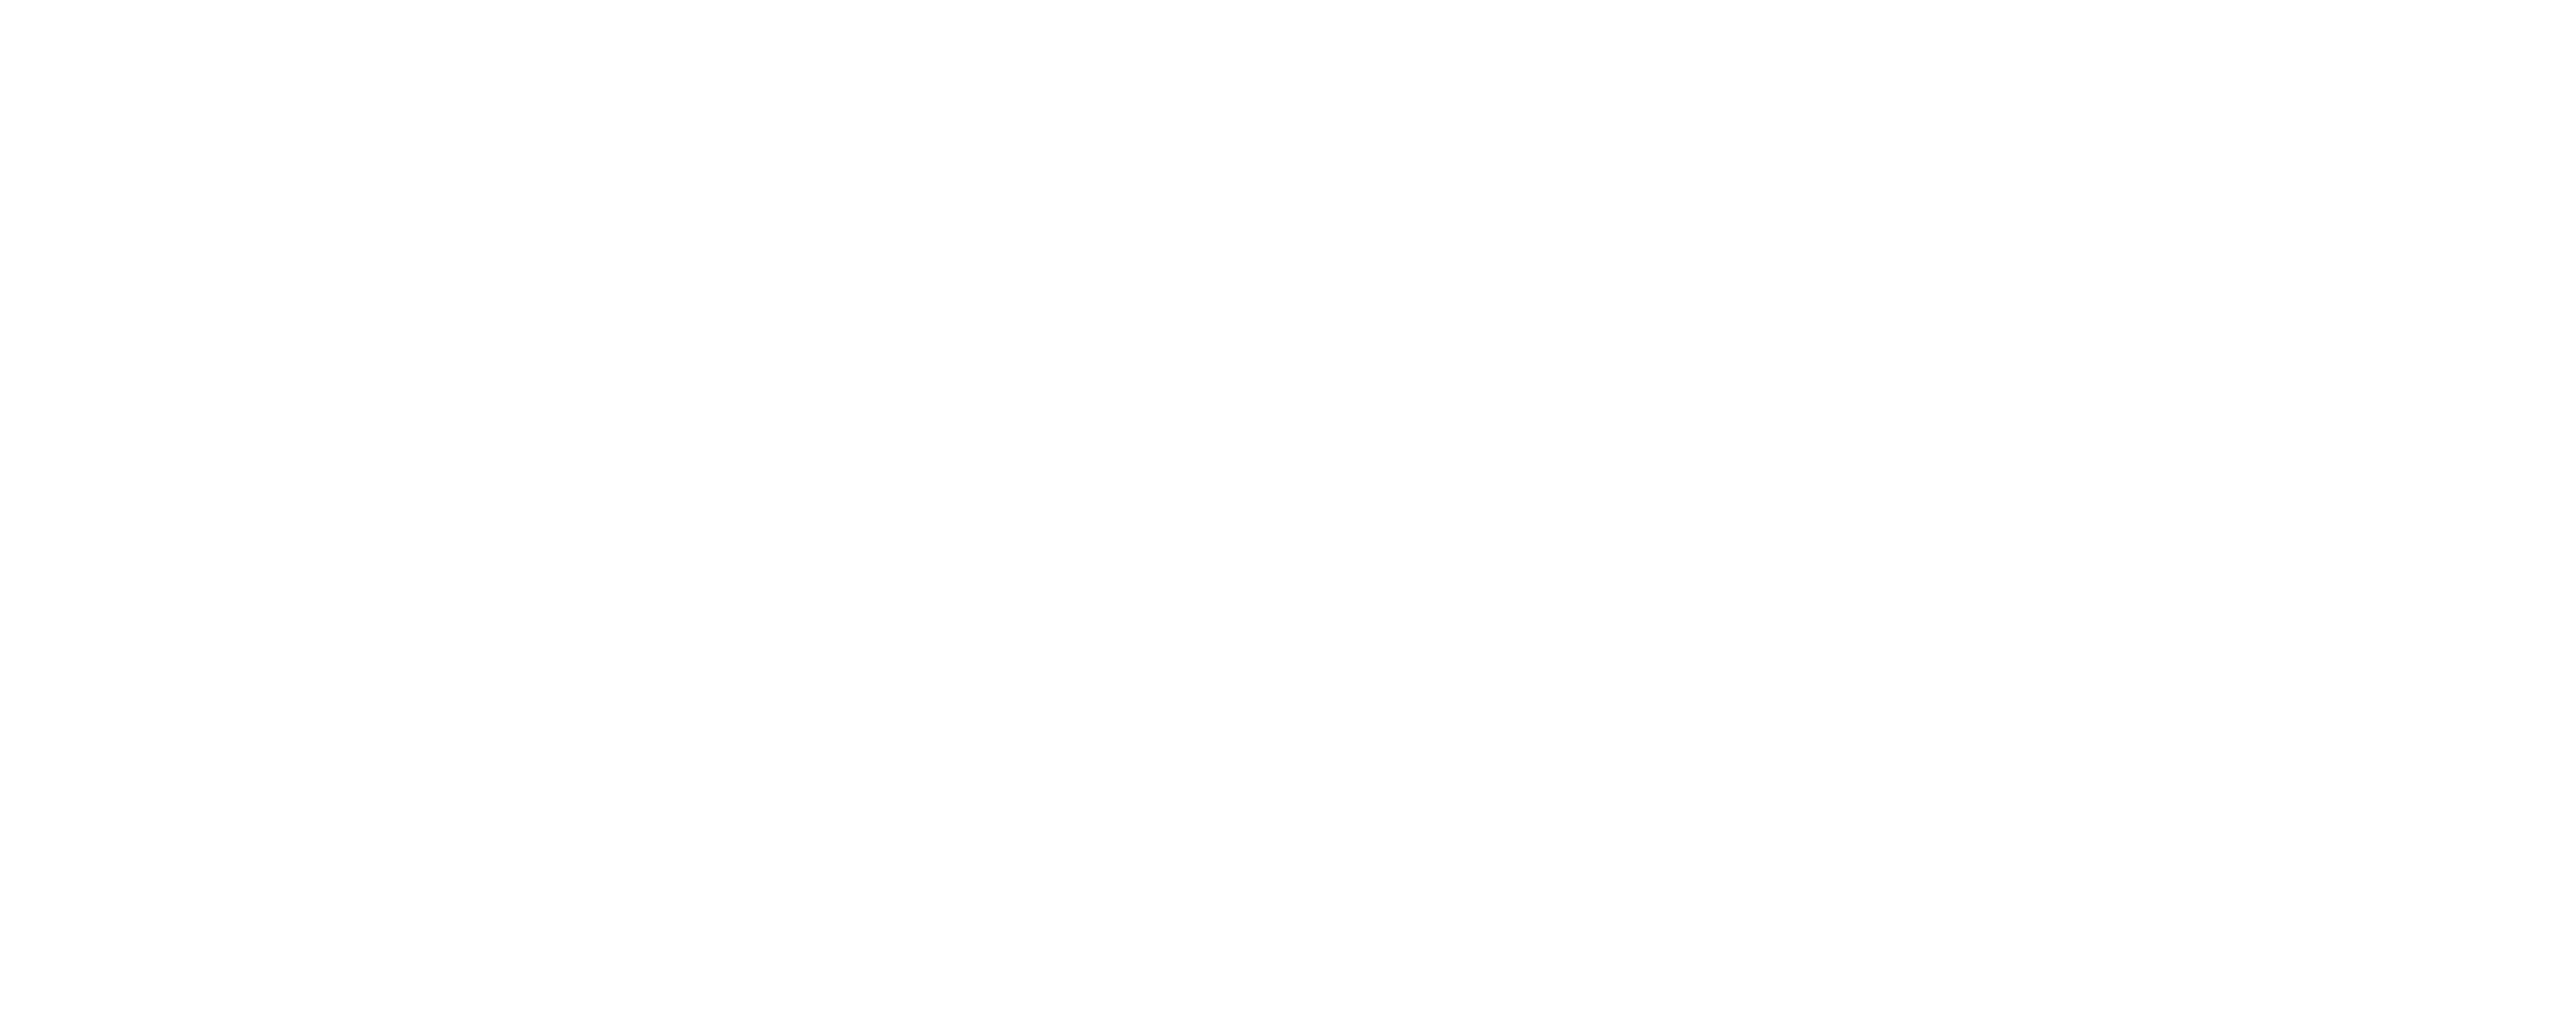

In [111]:
plotDAbeeswarm(da_results, group.by = "labels")

In [112]:
filt_results <- filter(da_results, !labels %in% c("Unassigned1", "Unassigned2", "Mixed") )

In [113]:
sign_Nhoods <- filt_results %>% filter(FDR<0.1) %>% 
  mutate(enrich = if_else(logFC >1, 'greater', 'less')) %>% 
  group_by(labels, enrich) %>%
  summarise(sign_Nhoods=n())

`summarise()` has grouped output by 'labels'. You can override using the `.groups` argument.


In [114]:
sign_Nhoods

labels,enrich,sign_Nhoods
<chr>,<chr>,<int>


In [115]:
total_Nhoods <- filt_results %>% group_by(labels) %>%
  summarise(noNhoods=n()) %>%
  full_join(sign_Nhoods, by='labels')

# total_Nhoods[is.na(total_Nhoods)] <- 0
total_Nhoods

labels,noNhoods,enrich,sign_Nhoods
<chr>,<int>,<chr>,<int>
a1_Tany-Astrocytes,210,NA,NA
a2_Tanycytes,213,NA,NA
a2_Tanycytes-b1_Tanycytes,107,NA,NA
Astrocytes,515,NA,NA
b1_Tanycytes,209,NA,NA
b2_Tany,78,NA,NA
Endothelial,4,NA,NA
Epend,42,NA,NA
Fibroblasts2-Fibroblasts3,5,NA,NA


In [116]:
total_Nhoods <- 
  total_Nhoods %>%
  mutate(proportionNhood = sign_Nhoods/noNhoods) %>%
  rename(labels = 'celltype')

ERROR: [1m[33mError[39m in [1m[1m`chr_as_locations()`:[22m
[33m![39m Can't rename columns that don't exist.
[31m✖[39m Column `celltype` doesn't exist.
